In [6]:
# In Class Exercises
# 1. In AI, datasets are often very large and cannot be processed all at once as is done in the loop above. The data is instead randomly sampled in smaller _batches_ where each _batch_ contains `batch_size` inputs. How can you change the loop above to sample the dataset in smaller batches? Hint: Our `data` variable is a Pandas `DataFrame` object, search for "how to sample a DataFrame".
# 2. As described above, learning rates that grow smaller over time can help find and get closer to global minima. In the loop above, our `learning_rate_m` and `learning_rate_b` are constant through the process of minimizing our parameters. How could you change the loop to reduce the learning rates over loop iterations?
# Homework
# Follow the example from the previous notebook [Linear Regression using SGD](./01_linear_regression_sgd.ipynb) and build a loop that properly finds the centers of these 4 clusters using k-means. 
# Addendum: aim for an accuracy of > 90%.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time


In [8]:
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)


Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')


Text(0, 0.5, 'Sale Price')

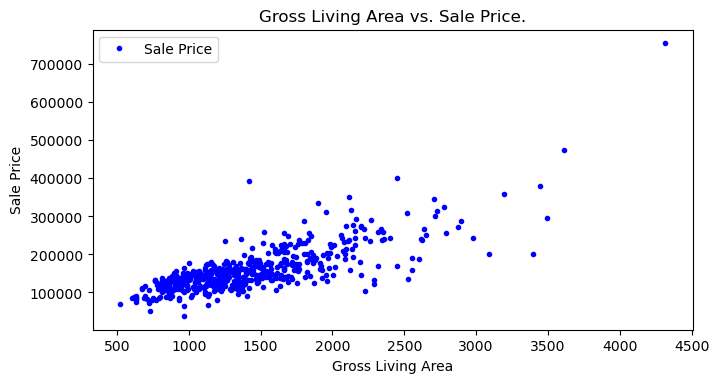

In [9]:

# Matplotlib
figure = plt.figure(figsize=(6, 3))
ax = figure.add_axes([1, 1, 1, 1])
ax.set_title("Gross Living Area vs. Sale Price.")
scatter = ax.plot(data.GrLivArea, data.SalePrice, '.b')
ax.legend(scatter, ["Sale Price"])
ax.set_xlabel("Gross Living Area")
ax.set_ylabel("Sale Price")


In [10]:
n = len(data)
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)
denominator = n * sum_x2 - sum_x * sum_x
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# saving these for later comparison
m_calc = m
b_calc = b


y = 87.688145 * x + 34754.077892
